# Code to analyze replay events

detect replay events using tools from nelpy https://github.com/nelpy/nelpy by Etienne Ackermann

In [1]:
%cd ..

D:\ryanh\github\cell_assembly_replay


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline
import os
import sys
from cell_assembly_replay import functions,replay_run,replay_fig

# import importlib
# importlib.reload(replay_fig)

import pandas as pd
import itertools
import statistics 
import math
from scipy import stats
from nelpy.analysis import replay

import multiprocessing
from joblib import Parallel, delayed

import statsmodels.api as sm

import glob
import pickle

### load data frames and important paths 

In [3]:
# output files are saved here
save_path = 'F:/Projects/PAE_PlaceCell/analysis/replay_nelpy/'
# where base data will be read in from
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# where spike times will be read in
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes/'
# data frame contain info for each unit
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
# data frame contain info for each population burst event
mua_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/multiunit_data/post_processed/mua_df.csv')

## test out code on single session

In [4]:
%%time

session = 'LEM3216_S20190718101925'

results = replay_run.run_all(session,data_path,spike_path,save_path,mua_df,df_cell_class)
results.keys()

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:432: UserWarning: estimated fs and provided fs differ by more than 1%
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:478: Us

Wall time: 1min 26s


dict_keys(['sta_placecells', 'bst_placecells', 'tc', 'posteriors', 'bdries', 'mode_pth', 'df', 'session', 'decoding_r2', 'decoding_mean_error'])

[ 9 16 27 31 64 79 88]
[ 9 11 16 17 27 31 40 64 79 88]


D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:1590: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


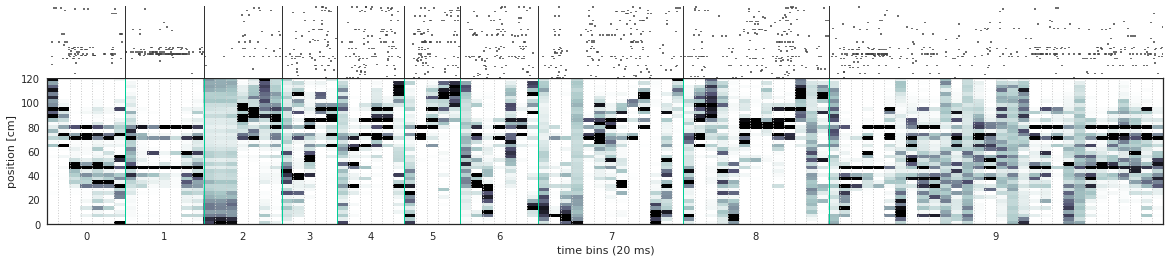

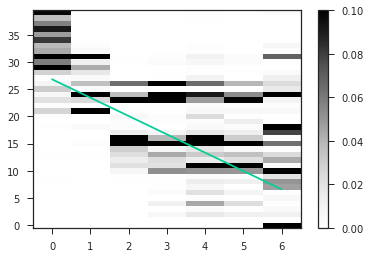

In [9]:
print(np.where((results['df']['pvalues_time_swap'] < 0.05) & (results['df'].n_active > 5))[0])
print(np.where((results['df']['pvalues_col_cycle'] < 0.05) & (results['df'].n_active > 5))[0])

idx = np.where((results['df']['pvalues_time_swap'] < 0.05) & (results['df'].n_active > 5))[0]
idx = np.where((results['df']['pvalues_col_cycle'] < 0.05) & (results['df'].n_active > 5))[0]


ax = replay_fig.plot_all_PBEs(results['bst_placecells'][idx], results['sta_placecells'], results['tc'], results['tc']) #idx=np.arange(0,13)

posterior = results['posteriors'][:,results['bdries'][9]:results['bdries'][9+1]]
plt.figure()
plt.imshow(posterior,aspect='auto',origin='lower',vmax=.1)
plt.colorbar()
x = np.arange(posterior.shape[1])
plt.plot(x,x*results['df'].slope.iloc[9]+results['df'].intercept.iloc[9])

# Run on all sessions

In [ ]:
replay_run.replay_run(data_path,spike_path,save_path,mua_df,df_cell_class,parallel=False)

# Load data back in

In [32]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + '*.pkl')
    
    df = []
    scores = []
    sig_event_idx = []
    pvalues = []
    traj_dist = []
    traj_speed = []
    traj_step = []
    replay_type = []
    dist_rat_start = []
    dist_rat_end = []
    decoding_r2 = []
    decoding_mean_error = []
    
    for session in sessions:
        with open(session, 'rb') as f:
            results = pickle.load(f)

        df.append(results['df'])
        scores.append(results['scores'])
        sig_event_idx.append(results['sig_event_idx'])
        pvalues.append(results['pvalues'])
        traj_dist.append(results['traj_dist'])
        traj_speed.append(results['traj_speed'])
        traj_step.append(results['traj_step'])
        replay_type.append(results['replay_type'])
        dist_rat_start.append(results['dist_rat_start'])
        dist_rat_end.append(results['dist_rat_end'])
        decoding_r2.append(results['decoding_r2'])
        decoding_mean_error.append(results['decoding_mean_error'])
                
    results = {
        "df": pd.concat(df),
        "scores": list(itertools.chain(*scores)),
        "sig_event_idx": list(itertools.chain(*sig_event_idx)),
        "pvalues": list(itertools.chain(*pvalues)),
        "traj_dist": list(itertools.chain(*traj_dist)),
        "traj_speed": list(itertools.chain(*traj_speed)),
        "traj_step": list(itertools.chain(*traj_step)),
        "replay_type": list(itertools.chain(*replay_type)),
        "dist_rat_start": list(itertools.chain(*dist_rat_start)),
        "dist_rat_end": list(itertools.chain(*dist_rat_end)),
        "decoding_r2": decoding_r2,
        "decoding_mean_error": decoding_mean_error
        }     
    return results

results = load_in_everything(save_path)
results.keys()

dict_keys(['df', 'scores', 'sig_event_idx', 'pvalues', 'traj_dist', 'traj_speed', 'traj_step', 'replay_type', 'dist_rat_start', 'dist_rat_end', 'decoding_r2', 'decoding_mean_error'])